# NAMA: FELIX PRATAMASAN
# EMAIL: felixpratama242@gmail.com

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
from google.colab import files
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Download Dataset from Kaggle

In [2]:
#you need to create your own API first in kaggle
#upload kaggle json

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"felixpratama","key":"a3f1e3c240e43be127334f9fe19c9a0e"}'}

In [3]:
#create a kaggle folder
!mkdir ~/.kaggle

In [4]:
#copy kaggle.json to folder created
!cp kaggle.json ~/.kaggle/

#permission for the json to act
! chmod 600 ~/.kaggle/kaggle.json

In [16]:
!kaggle datasets download -d ranja7/electricity-consumption

  0% 0.00/49.1k [00:00<?, ?B/s]
100% 49.1k/49.1k [00:00<00:00, 43.9MB/s]


# Read Dataset

In [17]:
test_local_zip = '/content/electricity-consumption.zip'
zip_ref = zipfile.ZipFile(test_local_zip, 'r')
zip_ref.extractall('/content/dataset')

zip_ref.close()

In [18]:
data = pd.read_csv('/content/dataset/daily_consumption.csv')

In [19]:
data.head()

,Site ID,Energy Consumption (kWh),Date
0,CCC0501,1611.86,11-01-2019
1,CCC0501,911.89,11-02-2019
2,CCC0501,939.28,11-03-2019
3,CCC0501,1570.04,11-04-2019
4,CCC0501,1562.43,11-05-2019


# Exploratory Data Analysist

In [20]:
data.isnull().sum()

Site ID                     948
Energy Consumption (kWh)    948
Date                          0
dtype: int64

In [24]:
data = data.dropna()

In [25]:
data.isnull().sum()

Site ID                     0
Energy Consumption (kWh)    0
Date                        0
dtype: int64

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8316 entries, 0 to 9263
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Site ID                   8316 non-null   object 
 1   Energy Consumption (kWh)  8316 non-null   float64
 2   Date                      8316 non-null   object 
dtypes: float64(1), object(2)
memory usage: 259.9+ KB


In [27]:
print('Total Data:{} \nTotal Columns: {}'.format(data.shape[0], data.shape[1]))

Total Data:8316 
Total Columns: 3


In [29]:
timestamp= data['Date']
value = data['Energy Consumption (kWh)']

Text(0.5, 1.0, 'Energy Consumption')

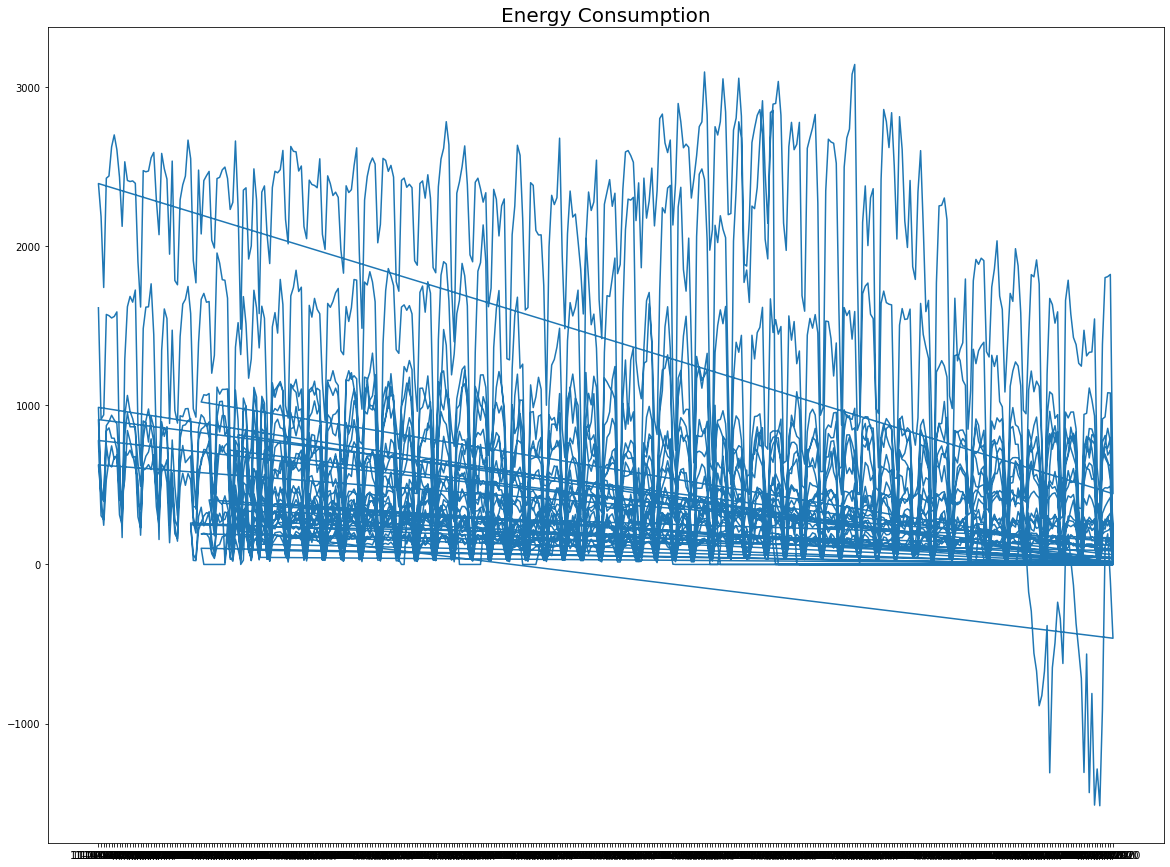

In [53]:
plt.figure(figsize=(20,15))
plt.plot(timestamp, value)
plt.title('Energy Consumption', fontsize=20)

# Preprocessing Data

In [30]:
reshape_value = value.values.reshape(-1,1)
scaler = MinMaxScaler()
scaler.fit(reshape_value)
normalized_value = scaler.transform(reshape_value)

In [31]:
x_train, x_test, y_train, y_test = train_test_split(normalized_value, timestamp, train_size=0.8, random_state=42)

In [32]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [33]:
train_set = windowed_dataset(x_train, window_size=64, batch_size=256, shuffle_buffer=1000)

# Build Model

In [35]:
max_val = normalized_value.max()
min_val = normalized_value.min()

In [36]:
print('maximum value: {}\nminimum value: {}'.format(max_val, min_val))

maximum value: 1.0
minimum value: 0.0


In [37]:
threshold = (max_val - min_val) * 10/100

In [38]:
print('Minimum MAE from this data: {}'.format(threshold))

Minimum MAE from this data: 0.1


In [47]:
model = Sequential([
    Conv1D(filters=64, kernel_size=5,
                          strides=1, padding='same',
                          activation='relu',
                          input_shape=[None, 1]),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(256)),
    Dense(32, activation="relu"),
    Dense(16, activation="relu"),
    Dense(1),
])

In [48]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, None, 64)          384       
                                                                 
 bidirectional_5 (Bidirectio  (None, None, 128)        66048     
 nal)                                                            
                                                                 
 bidirectional_6 (Bidirectio  (None, None, 256)        263168    
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 512)              1050624   
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 32)                16416     
                                                      

In [49]:
callbacks = EarlyStopping(monitor = 'loss',
                        patience = 3,
                        verbose = 1)

In [51]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set,epochs=20, callbacks=[callbacks], verbose=1)

Epoch 1/20
26/26 [==============================] - 11s 87ms/step - loss: 0.0140 - mae: 0.1220
Epoch 2/20
26/26 [==============================] - 2s 64ms/step - loss: 0.0125 - mae: 0.1089
Epoch 3/20
26/26 [==============================] - 2s 63ms/step - loss: 0.0112 - mae: 0.0962
Epoch 4/20
26/26 [==============================] - 2s 63ms/step - loss: 0.0101 - mae: 0.0873
Epoch 5/20
26/26 [==============================] - 2s 62ms/step - loss: 0.0093 - mae: 0.0811
Epoch 6/20
26/26 [==============================] - 2s 64ms/step - loss: 0.0087 - mae: 0.0768
Epoch 7/20
26/26 [==============================] - 2s 62ms/step - loss: 0.0082 - mae: 0.0743
Epoch 8/20
26/26 [==============================] - 2s 63ms/step - loss: 0.0078 - mae: 0.0728
Epoch 9/20
26/26 [==============================] - 2s 64ms/step - loss: 0.0075 - mae: 0.0720
Epoch 10/20
26/26 [==============================] - 2s 63ms/step - loss: 0.0073 - mae: 0.0718
Epoch 11/20
26/26 [==============================] - 2s 64

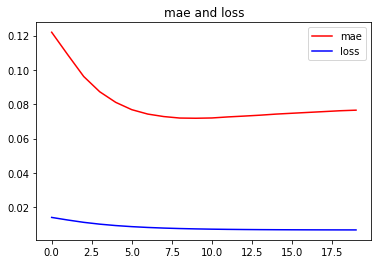

In [52]:
# Plot the training and validation accuracies for each epoch

mae = history.history['mae']
loss = history.history['loss']

epochs = range(len(mae))

plt.plot(epochs, mae, 'r', label='mae')
plt.plot(epochs, loss, 'b', label='loss')
plt.title('mae and loss')
plt.legend(loc=0)


plt.show()